# Way 1: Use Multiple Layer Peceptron

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END clf__activation=relu, clf__hidden_layer_sizes=(64,), clf__solver=sgd; total time=  16.6s
[CV] END clf__activation=relu, clf__hidden_layer_sizes=(64,), clf__solver=sgd; total time=  18.8s
[CV] END clf__activation=relu, clf__hidden_layer_sizes=(64,), clf__solver=sgd; total time=  19.3s
[CV] END clf__activation=relu, clf__hidden_layer_sizes=(64,), clf__solver=sgd; total time=  22.6s
[CV] END clf__activation=relu, clf__hidden_layer_sizes=(64,), clf__solver=sgd; total time=  23.8s
[CV] END clf__activation=relu, clf__hidden_layer_sizes=(128,), clf__solver=sgd; total time=  34.5s
[CV] END clf__activation=relu, clf__hidden_layer_sizes=(128,), clf__solver=sgd; total time=  36.8s
[CV] END clf__activation=relu, clf__hidden_layer_sizes=(128,), clf__solver=sgd; total time=  41.2s
[CV] END clf__activation=relu, clf__hidden_layer_sizes=(64,), clf__solver=adam; total time=  46.2s
[CV] END clf__activation=relu, clf__hidden_layer_size

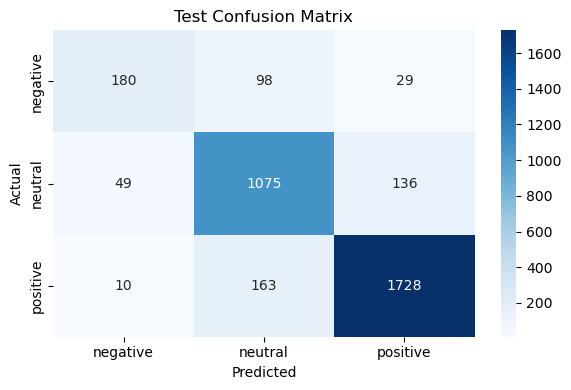

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('amazon_reviews.csv')
# Remove rows where having null values
df = df.dropna()
# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['sentiments'])
# Split dataset into train and test sets
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'], random_state=42)
# Create pipeline to extract and build model
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MLPClassifier(max_iter=300, random_state=42, early_stopping=True))
])
# Possible hyper-paramenters
param_grid = {
    'clf__hidden_layer_sizes': [(64,), (128,), (128, 64)],
    'clf__activation': ['relu', 'tanh'],
    'clf__solver': ['adam', 'sgd'],
}
# Run grid search using list of possible hyper-paramenters using cross-validation technique to get the best model
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)
grid.fit(train_val_df['cleaned_review'], train_val_df['label_encoded'])

print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)
# Use the best estimator (model) to make prediction on test set
best_model = grid.best_estimator_
test_preds = best_model.predict(test_df['cleaned_review'])
# Evaluate the model
print("\n=== Test Set Classification Report ===")
print(classification_report(test_df['label_encoded'], test_preds, target_names=label_encoder.classes_))
# Plot confusion matrix
def plot_confusion(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()
plot_confusion(test_df['label_encoded'], test_preds, label_encoder.classes_, title="Test Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(
    test_df['label_encoded'], 
    test_preds, 
    display_labels=label_encoder.classes_, 
    cmap=plt.cm.Blues, 
    normalize='true'
)

# Way 2: Use Naive Bayes

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ................clf__alpha=0.1, clf__fit_prior=True; total time=   0.3s
[CV] END ................clf__alpha=0.1, clf__fit_prior=True; total time=   0.4s
[CV] END ...............clf__alpha=0.1, clf__fit_prior=False; total time=   0.4s
[CV] END ................clf__alpha=0.5, clf__fit_prior=True; total time=   0.3s
[CV] END ...............clf__alpha=0.1, clf__fit_prior=False; total time=   0.4s
[CV] END ................clf__alpha=0.5, clf__fit_prior=True; total time=   0.3s
[CV] END ................clf__alpha=0.1, clf__fit_prior=True; total time=   0.4s
[CV] END ................clf__alpha=0.1, clf__fit_prior=True; total time=   0.4s
[CV] END ...............clf__alpha=0.1, clf__fit_prior=False; total time=   0.4s
[CV] END ...............clf__alpha=0.1, clf__fit_prior=False; total time=   0.3s
[CV] END ...............clf__alpha=0.1, clf__fit_prior=False; total time=   0.5s
[CV] END ...............clf__alpha=0.5, clf__fit_

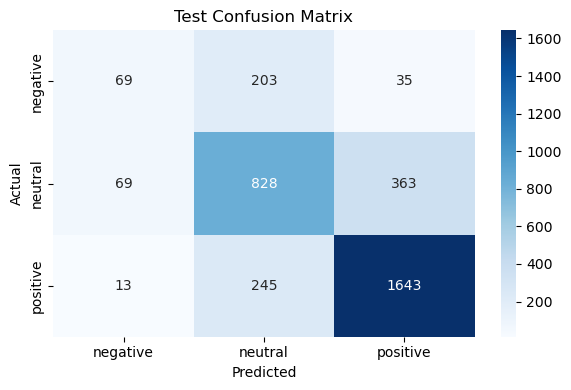

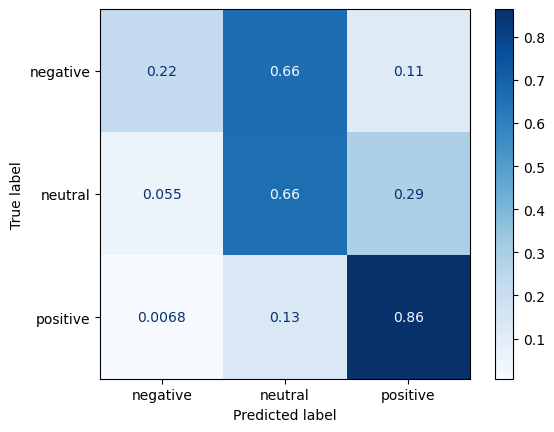

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('amazon_reviews.csv')
# Remove rows where having null values
df = df.dropna()
# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['sentiments'])
# Split dataset into train and test sets
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'], random_state=42)
# Create pipeline to extract and build model
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])
# Possible hyper-paramenters
param_grid = {
    'clf__alpha': [0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False],
}
# Run grid search using list of possible hyper-paramenters using cross-validation technique to get the best model
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)
grid.fit(train_val_df['cleaned_review'], train_val_df['label_encoded'])

print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)
# Use the best estimator (model) to make prediction on test set
best_model = grid.best_estimator_
test_preds = best_model.predict(test_df['cleaned_review'])
# Evaluate the model
print("\n=== Test Set Classification Report ===")
print(classification_report(test_df['label_encoded'], test_preds, target_names=label_encoder.classes_))
# Plot confusion matrix
def plot_confusion(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()
plot_confusion(test_df['label_encoded'], test_preds, label_encoder.classes_, title="Test Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(
    test_df['label_encoded'],
    test_preds,
    display_labels=label_encoder.classes_,
    cmap=plt.cm.Blues,
    normalize='true'
)